In [4]:
import json
import pickle
from collections import defaultdict
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

plt.rcParams["font.family"] = "serif"

In [5]:
results = sorted(list(Path("../results").glob("*.json")), reverse=True)

In [6]:
figure_dir = Path("../figures")
results_dir = Path("../results")

In [789]:
def load_results(
    path,
    results_dir=results_dir,
    exclude={"RandomEvaluator", "BetaShapley"},
    max_range=150,
    budget_dict=False,
    skip_mask=False, 
):
    results = json.load(open(results_dir / path))
    errors = results["errors"]
    runtimes = results["runtimes"]
    eval_range = np.array(results["eval_range"])
    if skip_mask:
        mask = np.array([True] * len(eval_range))
    else:
        # if "gaussian" in path:
        #     mask = eval_range < 30
        # else:
        mask = eval_range % 5 == 0
        mask[0] = True
    
    mask[eval_range > max_range] = False
        # eval_range = eval_range[mask]

    if budget_dict:
        error_dict = {k: defaultdict(list) for k in errors.keys() if k not in exclude}
        for k, v in errors.items():
            if k in exclude:
                continue
            for v_j in v:
                for b, e in v_j.items():
                    error_dict[k][int(b)].append(float(e))
        error_dict = {k: dict(sorted(v.items())) for k, v in error_dict.items()}
    else:
        error_dict = {
            k: np.array(
                [
                    [
                        float(v_ij)
                        for v_ij in (v_i.values() if isinstance(v_i, dict) else v_i)
                    ]
                    for v_i in v
                ]
            )
            for k, v in errors.items()
            if k not in exclude
        }
    runtime_dict = {k: np.array(v) for k, v in runtimes.items() if k not in exclude}

    return dict(
        errors=error_dict, runtimes=runtime_dict, eval_range=eval_range, mask=mask
    )

In [552]:
def get_mean_errors(results):
    eval_range = results["eval_range"]
    mask = results["mask"]
    errors = results["errors"]
    mean_errors = {k: v[:, mask].mean(0) for k, v in errors.items()}
    num_buyers = len(list(errors.values())[0])
    return dict(
        rang=eval_range[mask],
        mean_errors=mean_errors,
        num_buyers=num_buyers,
    )

In [35]:
color_map = {
    "Ours (multi-step)": "C0",
    "Ours (single step)": "C1",
    "DataOob": "C2",
    "DataShapley": "C3",
    "DVRL": "C4",
    "InfluenceSubsample": "C5",
    "KNNShapley": "C6",
    "LavaEvaluator": "C9",
    "LeaveOneOut": "C8",
    "Random": "darkgray",
}
label_map = {
    "Ours (multi-step)": "Ours (multi-step)",
    "Ours (single step)": "Ours (single step)",
    "DataOob": "Data OOB",
    "DataShapley": "Data Shapley",
    "DVRL": "DVRL",
    "InfluenceSubsample": "Influence",
    "KNNShapley": "KNN Shapley",
    "LavaEvaluator": "LAVA",
    "LeaveOneOut": "Leave One Out",
    "Random": "Random",
}

In [11]:
def config_style(
    key,
    ms=5,
    lw=2,
    base_marker="o",
    return_label=True,
):
    match key:
        case "Random":
            lw = 5
            ls = "--"
            marker = ""
        case "Ours (multi-step)" | "Ours (single step)":
            ls = "-"
            marker = "*"
            ms = ms + 5
        case _:
            ls = "-"
            marker = base_marker
    ret = dict(ms=ms, lw=lw, marker=marker, ls=ls, color=color_map[key])
    if return_label:
        ret["label"] = label_map[key]
    return ret

### overfitting

In [557]:
overfit_val_results = load_results('2024-01-24-220324-gaussian-1000-overfit_val-results.json')
agg_val_results = get_mean_errors(overfit_val_results)
overfit_dim_results = load_results('2024-01-25-183013-gaussian-1000-overfit_dim-results.json')
agg_dim_results = get_mean_errors(overfit_dim_results)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


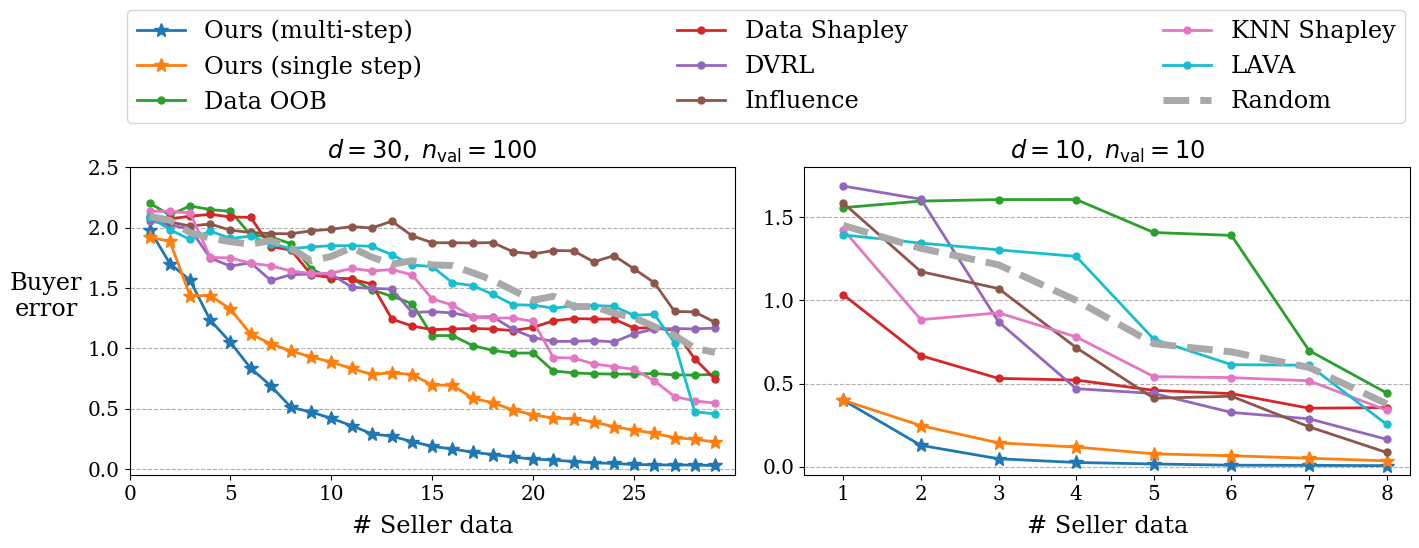

In [597]:
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(14, 4.), ncols=2)

for k, v in agg_dim_results['mean_errors'].items():
    kwargs = config_style(k, return_label=False)
    ax[0].plot(agg_dim_results['rang'], v, **kwargs)
    
for k, v in agg_val_results['mean_errors'].items():
    kwargs = config_style(k)
    ax[1].plot(agg_val_results['rang'][:8], v[:8], **kwargs)

ax[0].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[0].set_ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=30)
ax[1].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[0].set_title(r"$d=30,\;  n_\mathrm{val}=100$", fontsize="xx-large")
ax[1].set_title("$d=10,\;  n_\mathrm{val}=10$", fontsize="xx-large")

ax[0].set_xticks(np.arange(0, 30, 5))
ax[1].set_xticks(np.arange(0, 10, 1))
ax[0].set_yticks(np.arange(0, 3.1, 0.5))
ax[1].set_yticks(np.arange(0, 3.1, 0.5))
ax[0].set_xticklabels(ax[0].get_xticks(), fontsize="x-large")
ax[1].set_xticklabels(ax[1].get_xticks(), fontsize="x-large")
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize="x-large")
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize="x-large")
ax[0].set_ylim(-0.05, 2.5)
ax[1].set_ylim(-0.05, 1.8)

ax[0].set_xlim(0, 30)
ax[1].set_xlim(0.5, 8.3)

ax[0].grid(axis="y", ls="--")
ax[1].grid(axis="y", ls="--")

fig.legend(
    fontsize="xx-large",
    bbox_to_anchor=(0.075, 0.35, 0.93, 1),
    loc="upper center",
    ncols=3,
    mode="expand",
    # title="Data selection algorithms",
    # title_fontsize="xx-large",
)
plt.tight_layout(pad=0, w_pad=2)
plt.savefig(figure_dir / f"gauss-overfitting.eps", bbox_inches="tight")

### error analysis

In [719]:
# table_drug_results = load_results('2024-01-26-211649-drug-3500-main_table-results.json', exclude={'RandomEvaluator'})
table_drug_results = load_results('2024-01-29-162841-drug-3500-main_table-results.json', exclude={'RandomEvaluator'})
agg_table_drug_results = get_mean_errors(table_drug_results)
# table_fitz_results = load_results('2024-01-24-214254-fitzpatrick-15000-main_table-results.json', exclude={'RandomEvaluator'})
table_fitz_results = load_results('2024-01-27-175029-fitzpatrick-15000-main_table-results.json', exclude={'RandomEvaluator'})
agg_table_fitz_results = get_mean_errors(table_fitz_results)
table_bone_results = load_results('2024-01-27-175006-bone-12000-main_table-results.json', exclude={'RandomEvaluator'})
agg_table_bone_results = get_mean_errors(table_bone_results)

In [720]:
print(table_drug_results['errors']['DVRL'].shape)
print(table_fitz_results['errors']['DVRL'].shape)
print(table_bone_results['errors']['DVRL'].shape)

(100, 53)
(100, 53)
(100, 53)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


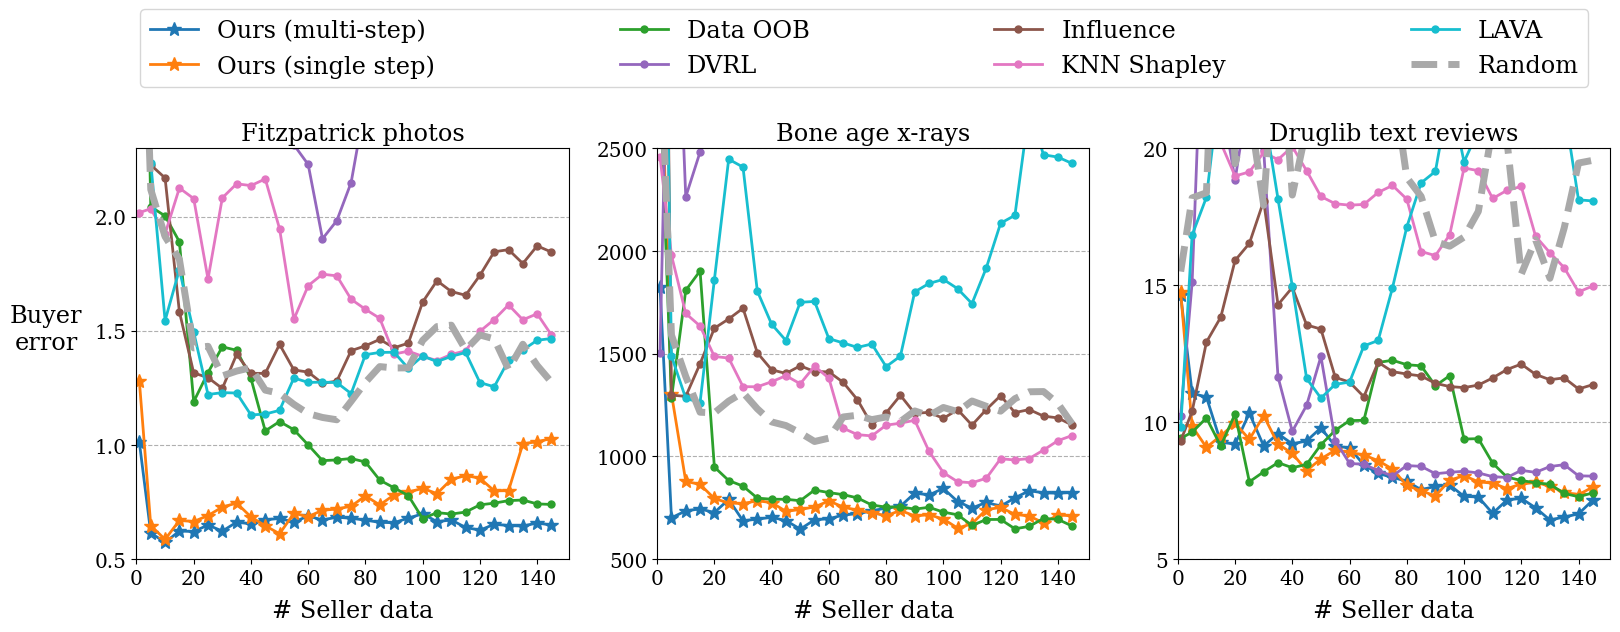

In [728]:
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(16, 5), ncols=3)

for k, v in agg_table_fitz_results['mean_errors'].items():
    kwargs = config_style(k, return_label=False)
    ax[0].plot(agg_table_fitz_results['rang'], v, **kwargs)
    
for k, v in agg_table_bone_results['mean_errors'].items():
    kwargs = config_style(k)
    ax[1].plot(agg_table_bone_results['rang'], v, **kwargs)
    
for k, v in agg_table_drug_results['mean_errors'].items():
    kwargs = config_style(k, return_label=False)
    ax[2].plot(agg_table_drug_results['rang'], v, **kwargs)

ax[0].set_ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=35)
ax[0].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[1].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[2].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[0].set_title("Fitzpatrick photos", fontsize="xx-large")
ax[1].set_title("Bone age x-rays", fontsize="xx-large")
ax[2].set_title("Druglib text reviews", fontsize="xx-large")

ax[0].set_xticks(np.arange(0, 151, 20))
ax[1].set_xticks(np.arange(0, 151, 20))
ax[2].set_xticks(np.arange(0, 151, 20))

ax[0].set_yticks(np.arange(0, 2.5, 0.5))
ax[1].set_yticks(np.arange(0, 3500, 500))
ax[2].set_yticks(np.arange(0, 50, 5))

ax[0].set_xticklabels(ax[0].get_xticks(), fontsize="x-large")
ax[1].set_xticklabels(ax[1].get_xticks(), fontsize="x-large")
ax[2].set_xticklabels(ax[2].get_xticks(), fontsize="x-large")
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize="x-large")
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize="x-large")
ax[2].set_yticklabels(ax[2].get_yticks(), fontsize="x-large")

ax[0].set_xlim(0, 151)
ax[1].set_xlim(0, 151)
ax[2].set_xlim(0, 151)

ax[0].set_ylim(0.5, 2.3)
ax[1].set_ylim(500, 2500)
ax[2].set_ylim(5, 20)

ax[0].grid(axis="y", ls="--")
ax[1].grid(axis="y", ls="--")
ax[2].grid(axis="y", ls="--")

fig.legend(
    fontsize="xx-large",
    bbox_to_anchor=(0.074, 0.25, 0.92, 1),
    loc="upper center",
    ncols=4,
    mode="expand",
    # title="Data selection algorithms",
    # title_fontsize="xx-large",
)
plt.tight_layout(pad=0, w_pad=2)
plt.savefig(figure_dir / f"embedded-multi-plot.eps", bbox_inches="tight")

In [797]:

table_fitz_results['eval_range']

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,
        80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140,
       145])

In [796]:
table_fitz_results['mask']

array([ True, False, False, False,  True, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False])

In [794]:
skip_mask = True
f = np.mean

max_range = 10 
table_gauss_1k_results = load_results('2024-01-26-111538-gaussian-1000-compare_runtime-results.json', exclude={'RandomEvaluator'}, max_range=max_range, skip_mask=skip_mask)
agg_table_gauss_1k_results = get_mean_errors(table_gauss_1k_results)
table_gauss_100k_results = load_results('2024-01-28-182942-gaussian-100000-compare_runtime-results.json', exclude={'RandomEvaluator'}, max_range=max_range, skip_mask=skip_mask)
agg_table_gauss_100k_results = get_mean_errors(table_gauss_100k_results)

table_mimic_35k_results = load_results('2024-01-25-175357-mimic-35000-main_table-results.json', exclude={'RandomEvaluator'}, max_range=max_range, skip_mask=skip_mask)
agg_table_mimic_35k_results = get_mean_errors(table_mimic_35k_results)
table_mimic_1k_results = load_results('2024-01-26-160532-mimic-1000-main_table-results.json', exclude={'RandomEvaluator'}, max_range=max_range, skip_mask=skip_mask)
agg_table_mimic_1k_results = get_mean_errors(table_mimic_1k_results)

skip_mask = False
max_range = 100
# table_drug_results = load_results('2024-01-26-211649-drug-3500-main_table-results.json', exclude={'RandomEvaluator'}, max_range=max_range, skip_mask=skip_mask)
table_drug_results = load_results('2024-01-29-162841-drug-3500-main_table-results.json', exclude={'RandomEvaluator'}, max_range=max_range, skip_mask=skip_mask)
agg_table_drug_results = get_mean_errors(table_drug_results)
# table_fitz_results = load_results('2024-01-24-214254-fitzpatrick-15000-main_table-results.json', exclude={'RandomEvaluator'}, max_range=max_range, skip_mask=skip_mask)
table_fitz_results = load_results('2024-01-27-175029-fitzpatrick-15000-main_table-results.json', exclude={'RandomEvaluator'}, max_range=max_range, skip_mask=skip_mask)
agg_table_fitz_results = get_mean_errors(table_fitz_results)
table_bone_results = load_results('2024-01-27-175006-bone-12000-main_table-results.json', exclude={'RandomEvaluator'}, max_range=max_range, skip_mask=skip_mask)
agg_table_bone_results = get_mean_errors(table_bone_results)

prec = 2
print('gauss 1k'.center(40, '#'))
for k, v in agg_table_gauss_1k_results["mean_errors"].items():
    print(k.center(40, "-"), agg_table_gauss_1k_results['num_buyers'])
    print(f(v).round(prec))
    print('\n')

prec = 2
print('gauss 100k'.center(40, '#'))
for k, v in agg_table_gauss_100k_results["mean_errors"].items():
    print(k.center(40, "-"), agg_table_gauss_1k_results['num_buyers'])
    print(f(v).round(prec))
    print('\n')
    
prec = 1
print('mimic 1k'.center(40, '#'))
for k, v in agg_table_mimic_1k_results["mean_errors"].items():
    print(k.center(40, "-"), agg_table_gauss_1k_results['num_buyers'])
    print(f(v).round(prec))
    print('\n')

print('mimic 35k'.center(40, '#'))
for k, v in agg_table_mimic_35k_results["mean_errors"].items():
    print(k.center(40, "-"), agg_table_gauss_1k_results['num_buyers'])
    print(f(v).round(prec))
    print('\n')

print('bone'.center(40, '#'))
for k, v in agg_table_bone_results["mean_errors"].items():
    print(k.center(40, "-"), agg_table_gauss_1k_results['num_buyers'])
    print(f(v).round(prec))
    print('\n')

prec=2
print('fitz'.center(40, '#'))
for k, v in agg_table_fitz_results["mean_errors"].items():
    print(k.center(40, "-"), agg_table_gauss_1k_results['num_buyers'])
    print(f(v).round(prec))
    print('\n')

prec=1
print('Drug'.center(40, '#'))
for k, v in agg_table_drug_results["mean_errors"].items():
    print(k.center(40, "-"), agg_table_gauss_1k_results['num_buyers'])
    print(f(v).round(prec))
    print('\n')

################gauss 1k################
-----------Ours (multi-step)------------ 100
0.37


-----------Ours (single step)----------- 100
0.58


----------------DataOob----------------- 100
1.24


--------------DataShapley--------------- 100
0.87


------------------DVRL------------------ 100
1.33


-----------InfluenceSubsample----------- 100
1.36


---------------KNNShapley--------------- 100
1.55


-------------LavaEvaluator-------------- 100
1.47


--------------LeaveOneOut--------------- 100
1.31


-----------------Random----------------- 100
1.38


###############gauss 100k###############
-----------Ours (multi-step)------------ 100
0.16


-----------Ours (single step)----------- 100
0.27


----------------DataOob----------------- 100
0.98


------------------DVRL------------------ 100
1.26


-----------InfluenceSubsample----------- 100
0.97


---------------KNNShapley--------------- 100
1.18


-------------LavaEvaluator-------------- 100
1.1


-----------------Random------------

In [767]:
table_gauss_1k_results = load_results('2024-01-26-111538-gaussian-1000-compare_runtime-results.json', exclude={'RandomEvaluator'})
agg_table_gauss_1k_results = get_mean_errors(table_gauss_1k_results)


table_gauss_100k_results = load_results('2024-01-28-182942-gaussian-100000-compare_runtime-results.json', exclude={'RandomEvaluator'})
agg_table_gauss_100k_results = get_mean_errors(table_gauss_100k_results)

table_gauss_5k_results = load_results('2024-01-28-182154-gaussian-5000-compare_runtime-results.json', exclude={'RandomEvaluator'})
agg_table_gauss_5k_results = get_mean_errors(table_gauss_5k_results )
table_gauss_10k_results = load_results('2024-01-30-064437-gaussian-10000-compare_runtime-results.json', exclude={'RandomEvaluator'})
agg_table_gauss_10k_results = get_mean_errors(table_gauss_10k_results )
# table_gauss_50k_results = load_results('2024-01-28-041745-gaussian-50000-compare_runtime-results.json', exclude={'RandomEvaluator'})
# agg_table_gauss_50k_results = get_mean_errors(table_gauss_50k_results )

table_mimic_35k_results = load_results('2024-01-25-175357-mimic-35000-main_table-results.json', exclude={'RandomEvaluator'}, skip_mask=True)
agg_table_mimic_35k_results = get_mean_errors(table_mimic_35k_results)
table_mimic_1k_results = load_results('2024-01-26-160532-mimic-1000-main_table-results.json', exclude={'RandomEvaluator'}, skip_mask=True)
agg_table_mimic_1k_results = get_mean_errors(table_mimic_1k_results)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1000x500 with 0 Axes>

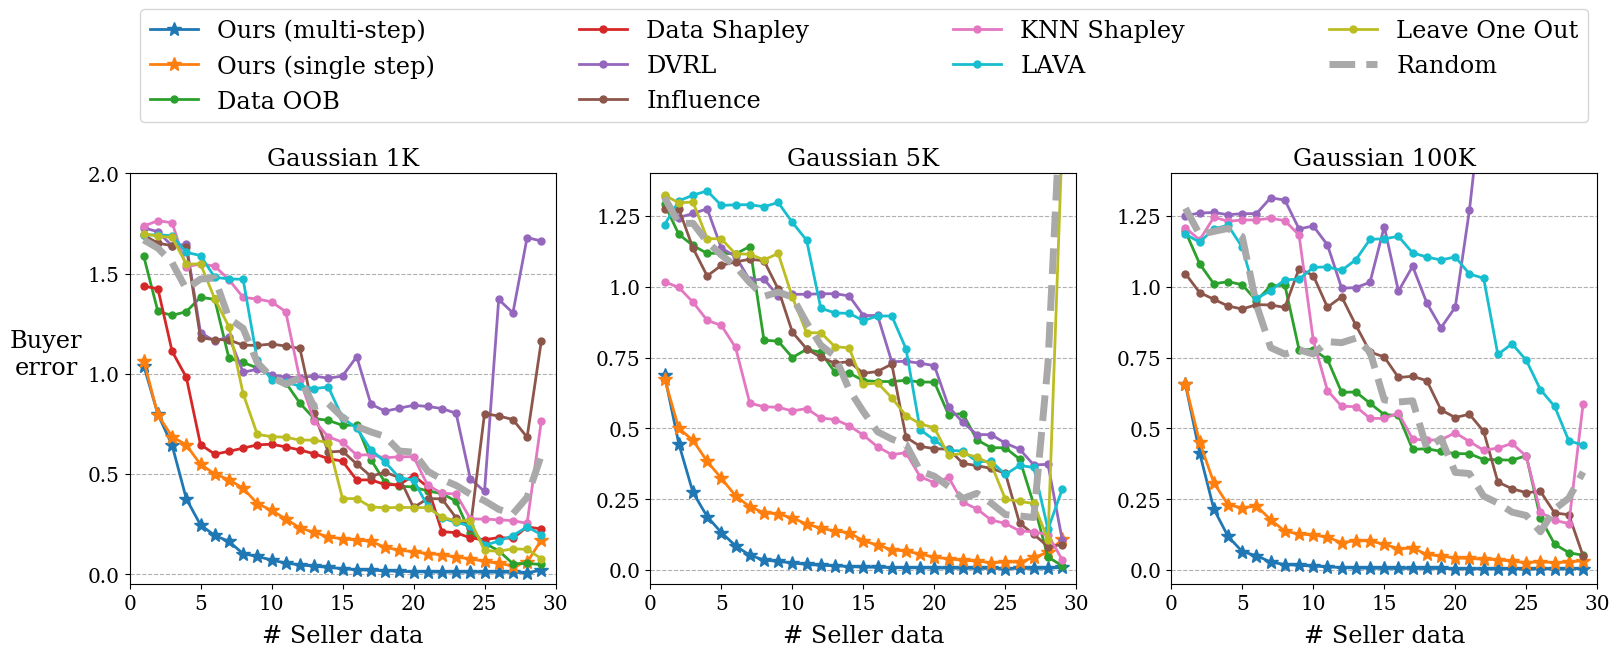

In [639]:
plt.figure(figsize=(10, 5))

# fig, ax = plt.subplots(figsize=(14, 4), ncols=2)
fig, ax = plt.subplots(figsize=(16, 5), ncols=3)

for k, v in agg_table_gauss_1k_results['mean_errors'].items():
    ax[0].plot(agg_table_gauss_1k_results['rang'], v, **config_style(k))

for k, v in agg_table_gauss_5k_results['mean_errors'].items():
    ax[1].plot(agg_table_gauss_5k_results['rang'], v, **config_style(k, return_label=False))

# for k, v in agg_table_gauss_10k_results['mean_errors'].items():
#     ax[1].plot(agg_table_gauss_10k_results['rang'], v, **config_style(k, return_label=False))
    
for k, v in agg_table_gauss_100k_results['mean_errors'].items():
    ax[2].plot(agg_table_gauss_100k_results['rang'], v, **config_style(k, return_label=False))
    

ax[0].set_xticks(np.arange(0, 31, 5))
ax[1].set_xticks(np.arange(0, 31, 5))
ax[2].set_xticks(np.arange(0, 31, 5))

ax[0].set_yticks(np.arange(0, 2.1, 0.5))
ax[1].set_yticks(np.arange(0, 2.1, 0.25))
ax[2].set_yticks(np.arange(0, 2.1, 0.25))

ax[0].set_xticklabels(ax[0].get_xticks(), fontsize="x-large")
ax[1].set_xticklabels(ax[1].get_xticks(), fontsize="x-large")
ax[2].set_xticklabels(ax[2].get_xticks(), fontsize="x-large")

ax[0].set_yticklabels(ax[0].get_yticks(), fontsize="x-large")
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize="x-large")
ax[2].set_yticklabels(ax[2].get_yticks(), fontsize="x-large")

ax[0].set_ylim(-0.05, 2.0)
ax[1].set_ylim(-0.05, 1.4)
ax[2].set_ylim(-0.05, 1.4)
ax[0].set_xlim(0, 30)
ax[1].set_xlim(0, 30)
ax[2].set_xlim(0, 30)

ax[0].set_ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=30)
ax[0].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[1].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[2].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
# ax[0].set_title("Gaussian-1K", fontsize="xx-large")
# ax[1].set_title("Gaussian-100K", fontsize="xx-large")
ax[0].set_title("Gaussian 1K", fontsize="xx-large")
ax[1].set_title("Gaussian 5K", fontsize="xx-large")
ax[2].set_title("Gaussian 100K", fontsize="xx-large")

# ax[1].barh(
#     list(runtime_arr.keys()),
#     [v.mean() for v in runtime_arr.values()],
#     color=[color_map[k] for k in runtime_arr.keys()],
# )
# ax[1].xticks(fontsize='x-large')
# ax[1].xlabel('Runtime (seconds)', fontsize='xx-large')
ax[0].grid(axis="y", ls="--")
ax[1].grid(axis="y", ls="--")
ax[2].grid(axis="y", ls="--")
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
# ax[0].set_ylim(100, 1000)
# ax[1].set_ylim(100, 1000)

fig.legend(
    fontsize="xx-large",
    bbox_to_anchor=(0.074, 0.30, 0.92, 1),
    loc="upper center",
    ncols=4,
    mode="expand",
    # title="Data selection algorithms",
    # title_fontsize="xx-large",
)
plt.tight_layout(pad=0, w_pad=2)
plt.savefig(figure_dir / f"gauss-num-error.eps", bbox_inches="tight")

<Figure size 1000x500 with 0 Axes>

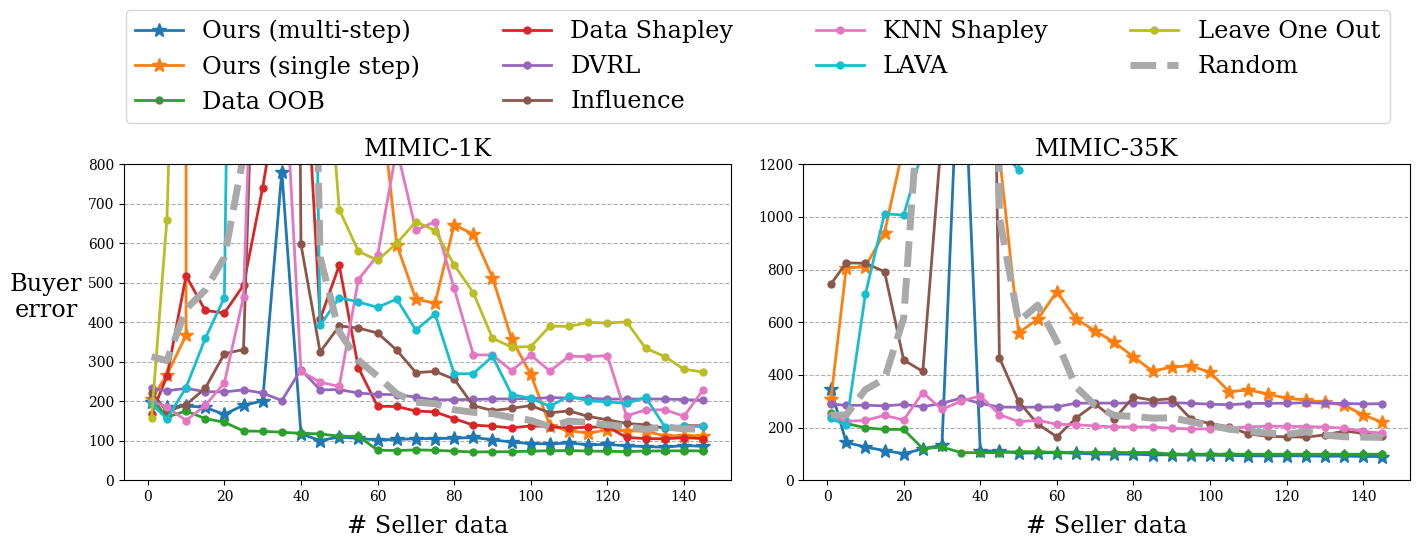

In [762]:
plt.figure(figsize=(10, 5))

fig, ax = plt.subplots(figsize=(14, 4), ncols=2)

for k, v in agg_table_mimic_1k_results['mean_errors'].items():
    ax[0].plot(agg_table_mimic_1k_results['rang'], v, **config_style(k))

for k, v in agg_table_mimic_35k_results['mean_errors'].items():
    ax[1].plot(agg_table_mimic_35k_results['rang'], v, **config_style(k, return_label=False))

# ax[0].set_xticks(np.arange(0, 30, 5))
# ax[0].set_yticks(np.arange(0, 3, 0.5))
# ax[0].set_xticklabels(ax[0].get_xticks(), fontsize="x-large")
# ax[0].set_yticklabels(ax[0].get_yticks(), fontsize="x-large")
# ax[0].set_xlim(0, 28)

# ax[1].set_xticks(np.arange(0, 155, 25))
# ax[1].set_yticks(np.arange(0, 2000, 500))
# ax[1].set_xticklabels(ax[1].get_xticks(), fontsize="x-large")
# ax[1].set_yticklabels(ax[1].get_yticks(), fontsize="x-large")
ax[0].set_ylim(0, 800)
ax[1].set_ylim(0, 1200)
# ax[0].set_xlim(0, 30)
# ax[1].set_xlim(0, 30)

ax[0].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[0].set_ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=30)
ax[1].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[0].set_title("MIMIC-1K", fontsize="xx-large")
ax[1].set_title("MIMIC-35K", fontsize="xx-large")

# ax[1].barh(
#     list(runtime_arr.keys()),
#     [v.mean() for v in runtime_arr.values()],
#     color=[color_map[k] for k in runtime_arr.keys()],
# )
# ax[1].xticks(fontsize='x-large')
# ax[1].xlabel('Runtime (seconds)', fontsize='xx-large')
ax[0].grid(axis="y", ls="--")
ax[1].grid(axis="y", ls="--")
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
# ax[0].set_ylim(100, 1000)
# ax[1].set_ylim(100, 1000)

fig.legend(
    fontsize="xx-large",
    bbox_to_anchor=(0.074, 0.35, 0.92, 1),
    loc="upper center",
    ncols=4,
    mode="expand",
    # title="Data selection algorithms",
    # title_fontsize="xx-large",
)
plt.tight_layout(pad=0, w_pad=2)
# plt.savefig(figure_dir / f"mimic-compare-error.eps", bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


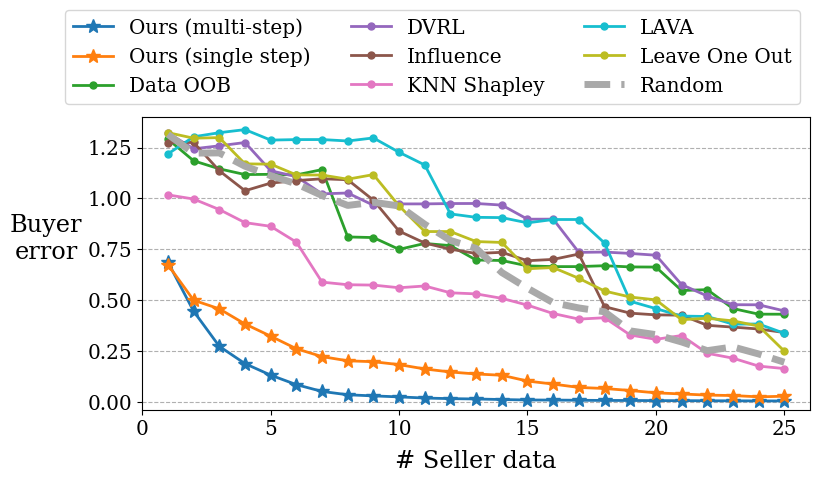

In [624]:
plt.figure(figsize=(8, 5))

for k, v in agg_table_gauss_5k_results['mean_errors'].items():
    plt.plot(agg_table_gauss_5k_results['rang'][:25], v[:25], **config_style(k))

plt.xticks(np.arange(0, 27, 5), fontsize="x-large")
plt.yticks(np.arange(0, 2.0, 0.25), fontsize="x-large")
plt.xlim(0, 26)
plt.ylim(-0.04, 1.4)

plt.ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=30)
plt.xlabel("# Seller data", fontsize="xx-large", labelpad=8)
plt.grid(axis="y", ls="--")

# plt.legend(fontsize='x-large')
plt.legend(
    fontsize="x-large",
    bbox_to_anchor=(1.00, 1.40),
    loc="upper right",
    ncols=3,
)
plt.tight_layout(pad=0, w_pad=2)
plt.savefig(figure_dir / f"gauss-5k.eps", bbox_inches="tight")

### Budget analysis

In [899]:
gauss_squared_results = load_results('2024-01-29-203634-gaussian-10000-squared-noise_3-results.json', budget_dict=True)
mimic_squared_results = load_results('2024-01-27-203753-mimic-35000-squared-noise_3-results.json', budget_dict=True)
bone_squared_results = load_results('2024-01-27-203834-bone-12000-squared-noise_3-results.json', budget_dict=True)
fitz_squared_results = load_results('2024-01-28-173344-fitzpatrick-15000-squared-noise_3-results.json', budget_dict=True)
drug_squared_results = load_results('2024-01-29-202959-drug-3500-squared-noise_3-results.json', budget_dict=True)

gauss_root_results = load_results('2024-01-27-211454-gaussian-10000-square_root-results.json', budget_dict=True)
mimic_root_results = load_results('2024-01-28-201120-mimic-35000-square_root-noise_3-results.json', budget_dict=True)
bone_root_results = load_results('2024-01-30-021656-bone-12000-square_root-noise_3-results.json', budget_dict=True)
fitz_root_results = load_results('2024-01-30-021435-fitzpatrick-15000-square_root-noise_3-results.json', budget_dict=True)
# drug_root_results = load_results('2024-01-28-063141-drug-3500-square_root-noise_3-results.json', budget_dict=True)
drug_root_results = load_results('2024-01-30-163757-drug-4000-square_root-noise_3-results.json', budget_dict=True)


Ours (multi-step) 168.87
Ours (single step) 598.42
DataOob 242.81
DVRL 213.86
KNNShapley 217.05
LavaEvaluator 482.15
-----------num data----------- 100
Random 288.26


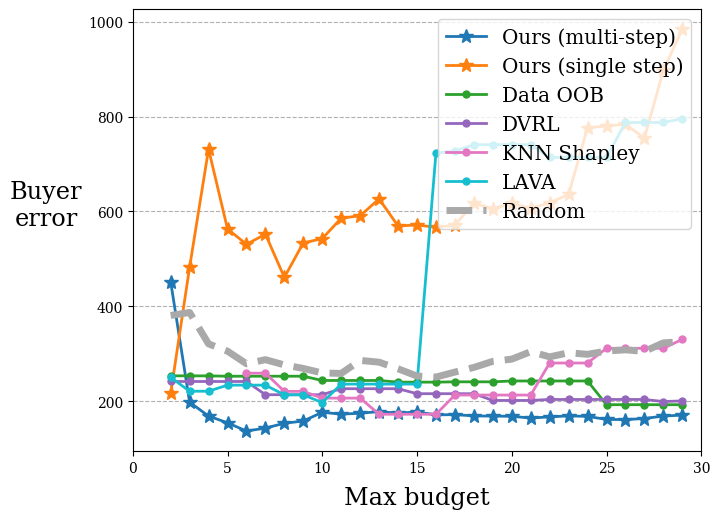

In [914]:
# agg_fitz_squared_results
eval_range = list(np.arange(0, 30))

plt.figure(figsize=(7, 5))

prec = 1
prec = 2
# for k, v in gauss_squared_results["errors"].items():
# for k, v in mimic_squared_results["errors"].items():
# for k, v in bone_squared_results["errors"].items():
# for k, v in fitz_squared_results["errors"].items():
# for k, v in drug_squared_results["errors"].items():

# for k, v in gauss_root_results["errors"].items():
for k, v in mimic_root_results["errors"].items():
# for k, v in bone_root_results["errors"].items():
# for k, v in fitz_root_results["errors"].items():
# for k, v in drug_root_results["errors"].items():
    if k == 'Random':
        print('num data'.center(30, '-'), len(v[9]))
    print(k,
        np.median([np.mean(v_i) for k, v_i in v.items() if k in eval_range]).round(prec),
         )
    plt.plot(
        # cost_results['eval_range'][1:],
        [v_i for v_i in v.keys() if v_i in eval_range],
        [np.mean(v_i) for k, v_i in v.items() if k in eval_range],
        **config_style(k),
    )
# plt.title(fontsize='xx-large')
# plt.xticks(np.arange(0, 110, 5), fontsize="x-large")
# plt.yticks(np.arange(0, 5001, 1000), fontsize="x-large")

plt.xlim(0, 30)

# plt.ylim(0, 10)
# plt.ylim(5, 35)
# plt.ylim(0, 1000)
# plt.ylim(500, 4500)
# plt.ylim(500, 4200)

plt.ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=30)
plt.xlabel("Max budget", fontsize="xx-large", labelpad=8)
plt.grid(axis="y", ls="--")

plt.legend(fontsize='x-large', loc='upper right')
# plt.legend(
#     fontsize="x-large",
#     bbox_to_anchor=(1.01, 1.3),
#     loc="upper right",
#     ncols=3,
# )
plt.tight_layout(pad=0, w_pad=2)
# plt.savefig(figure_dir / f"gauss-budget.eps", bbox_inches="tight")
# plt.savefig(figure_dir / f"drug-budget.eps", bbox_inches="tight")
# plt.savefig(figure_dir / f"fitz-budget.eps", bbox_inches="tight")
# plt.savefig(figure_dir / f"bone-budget-12k.eps", bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


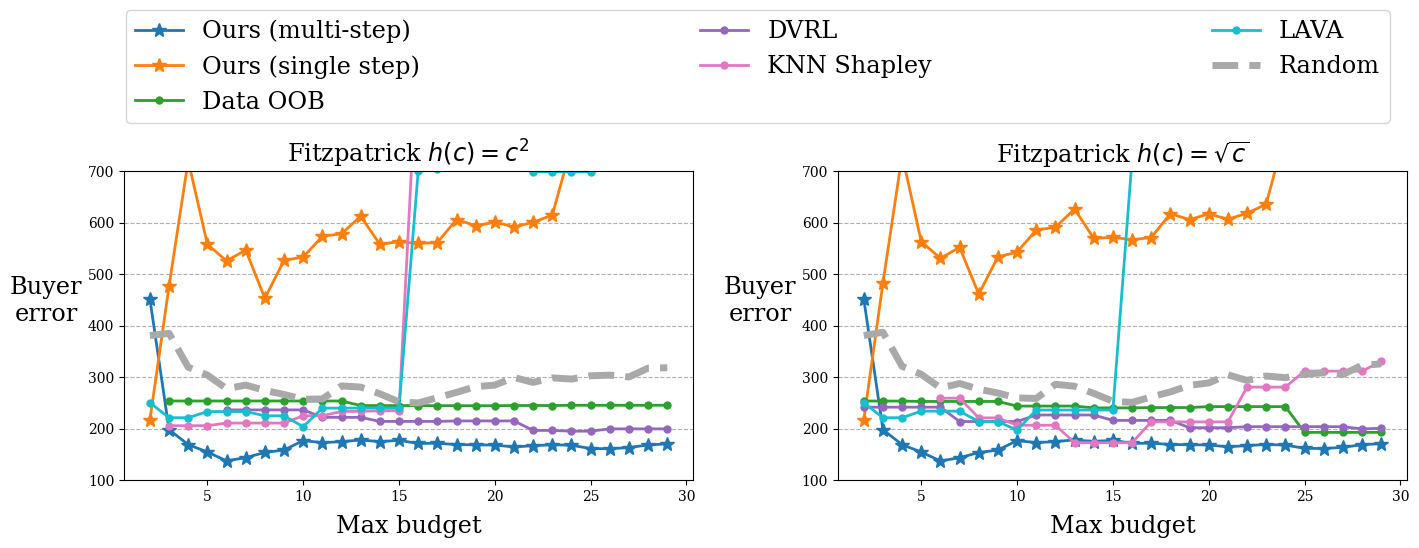

In [907]:
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(14, 4), ncols=2)

# for k, v in gauss_squared_results["errors"].items():
for k, v in mimic_squared_results["errors"].items():
# for k, v in fitz_squared_results["errors"].items():
    kwargs = config_style(k)
    ax[0].plot(
        [v_i for v_i in v.keys() if v_i in eval_range],
        [np.mean(v_i) for k, v_i in v.items() if k in eval_range],
        **kwargs,
    )

    
# for k, v in gauss_root_results["errors"].items():
for k, v in mimic_root_results["errors"].items():
# for k, v in fitz_root_results["errors"].items():
    kwargs = config_style(k, return_label=False)
    ax[1].plot(
        [v_i for v_i in v.keys() if v_i in eval_range],
        [np.mean(v_i) for k, v_i in v.items() if k in eval_range],
        **kwargs,
    )
# ax[0].set_xticks(np.arange(0, 30, 5))
# ax[0].set_yticks(np.arange(0, 3, 0.5))
# ax[0].set_xticklabels(ax[0].get_xticks(), fontsize="x-large")
# ax[0].set_yticklabels(ax[0].get_yticks(), fontsize="x-large")

# ax[1].set_xticks(np.arange(0, 155, 25))
# ax[1].set_yticks(np.arange(0, 2000, 500))
# ax[1].set_xticklabels(ax[1].get_xticks(), fontsize="x-large")
# ax[1].set_yticklabels(ax[1].get_yticks(), fontsize="x-large")
    
ax[0].set_ylim(0, 5)
ax[1].set_ylim(0, 5)

ax[0].set_ylim(100, 700)
ax[1].set_ylim(100, 700)

# ax[0].set_ylim(0, 6)
# ax[1].set_ylim(0, 4.5)


ax[0].set_xlabel("Max budget", fontsize="xx-large", labelpad=8)
ax[0].set_ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=30)
plt.ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=30)
ax[1].set_xlabel("Max budget", fontsize="xx-large", labelpad=8)

ax[0].set_title(r"Gaussian $h(c) = c^2$", fontsize="xx-large")
ax[1].set_title(r"Gaussian $h(c) = \sqrt{c}$", fontsize="xx-large")

ax[0].set_title(r"MIMIC $h(c) = c^2$", fontsize="xx-large")
ax[1].set_title(r"MIMIC $h(c) = \sqrt{c}$", fontsize="xx-large")

ax[0].set_title(r"Fitzpatrick $h(c) = c^2$", fontsize="xx-large")
ax[1].set_title(r"Fitzpatrick $h(c) = \sqrt{c}$", fontsize="xx-large")

ax[0].grid(axis="y", ls="--")
ax[1].grid(axis="y", ls="--")


fig.legend(
    fontsize="xx-large",
    bbox_to_anchor=(0.074, 0.35, 0.92, 1),
    loc="upper center",
    ncols=3,
    mode="expand",
    # title="Data selection algorithms",
    # title_fontsize="xx-large",
)
plt.tight_layout(pad=0, w_pad=2)
# plt.savefig(figure_dir / f"gauss-cost-compare.eps", bbox_inches="tight")
plt.savefig(figure_dir / f"mimic-cost-compare.eps", bbox_inches="tight")
# plt.savefig(figure_dir / f"fitz-cost-compare.eps", bbox_inches="tight")

### Runtime analysis


In [676]:
runtime_dim_10 = load_results('2024-01-26-054325-gaussian-1000-dim_runtime-results.json')
mean_runtime_dim_10 = get_mean_errors(runtime_dim_10 )
runtime_dim_50 = load_results('2024-01-27-060307-gaussian-1000-dim_runtime-results.json')
mean_runtime_dim_50 = get_mean_errors(runtime_dim_50 )
runtime_dim_100 = load_results('2024-01-27-074335-gaussian-1000-dim_runtime-results.json')
mean_runtime_dim_100 = get_mean_errors(runtime_dim_100 )
runtime_dim_500 = load_results('2024-01-27-133128-gaussian-1000-dim_runtime-results.json')
mean_runtime_dim_500 = get_mean_errors(runtime_dim_500 )
runtime_dim_1000 = load_results('2024-01-28-172813-gaussian-1000-dim_runtime-results.json')
mean_runtime_dim_1000 = get_mean_errors(runtime_dim_1000 )

In [703]:
runtime_mean = defaultdict(list)
runtime_std = defaultdict(list)

for k, v in runtime_dim_10['runtimes'].items():
    runtime_mean[k].append(v.mean())
    runtime_std[k].append(v.std())
    
for k, v in runtime_dim_50['runtimes'].items():
    runtime_mean[k].append(v.mean())
    runtime_std[k].append(v.std())
    
for k, v in runtime_dim_100['runtimes'].items():
    runtime_mean[k].append(v.mean())
    runtime_std[k].append(v.std())
    print(len(v))
    
for k, v in runtime_dim_500['runtimes'].items():
    runtime_mean[k].append(v.mean())
    runtime_std[k].append(v.std())
    
for k, v in runtime_dim_1000['runtimes'].items():
    runtime_mean[k].append(v.mean())
    runtime_std[k].append(v.std())

100
100
100
100
100
100
100
100


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


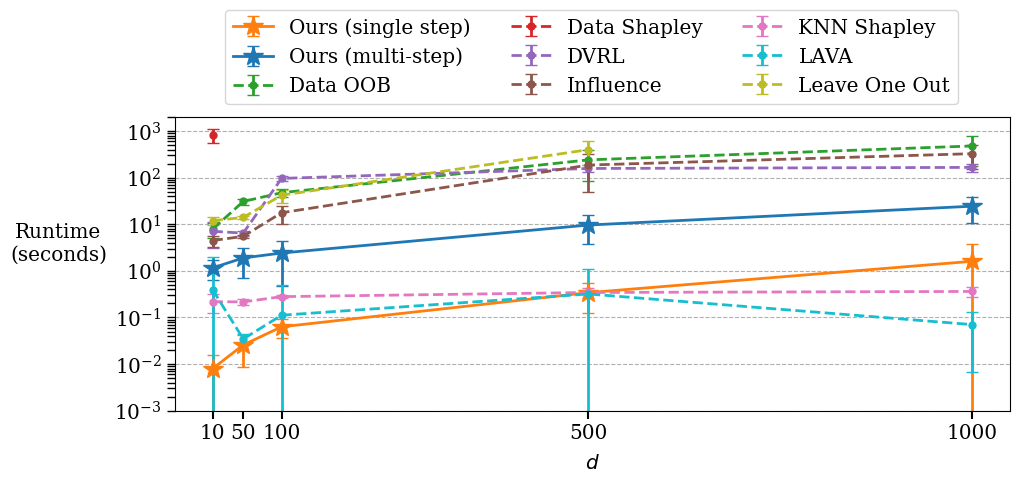

In [682]:
eval_range = list(np.arange(5, 115, 5))

plt.figure(figsize=(10, 5))

x = [10, 50, 100, 500, 1000]
for k, v in runtime_mean.items():
    kwargs = config_style(k)
    if 'Ours' in k:
        kwargs['lw'] = 2
        kwargs['ms'] = 15
    else:
        kwargs['ls'] = '--'
    plt.errorbar(
        x[:len(v)],
        v,
        yerr=runtime_std[k],
        capsize=4,
        **kwargs,
    )
plt.xticks([10, 50, 100, 500, 1000], fontsize="x-large")
plt.yticks(fontsize="x-large")
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1.5)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
# plt.xlim(5, 105)

plt.ylabel("Runtime\n(seconds)", fontsize="x-large", rotation=0, labelpad=40)
plt.xlabel(r"$d$", fontsize="x-large", labelpad=8)

plt.grid(axis="y", ls="--")
plt.ylim(0.001, 2000)
plt.yscale('log')

plt.legend(
    fontsize="x-large",
    bbox_to_anchor=(0.95, 1.40),
    loc="upper right",
    ncols=3,
)
plt.tight_layout(pad=0, w_pad=2)
plt.savefig(figure_dir / f"runtime_dim.eps", bbox_inches="tight")

In [688]:
runtime_num_500 = load_results('2024-01-25-183100-gaussian-500-compare_runtime-results.json')
mean_runtime_num_500 = get_mean_errors(runtime_num_500 )
runtime_num_1000 = load_results('2024-01-26-054325-gaussian-1000-dim_runtime-results.json')
mean_runtime_num_1000 = get_mean_errors(runtime_num_1000 )
runtime_num_5000 = load_results('2024-01-28-182154-gaussian-5000-compare_runtime-results.json')
mean_runtime_num_5000 = get_mean_errors(runtime_num_5000 )
runtime_num_1000 = load_results('2024-01-30-064437-gaussian-10000-compare_runtime-results.json')
mean_runtime_num_1000 = get_mean_errors(runtime_num_1000 )
runtime_num_50000 = load_results('2024-01-28-041745-gaussian-50000-compare_runtime-results.json')
mean_runtime_num_50000 = get_mean_errors(runtime_num_50000 )
runtime_num_100000 = load_results('2024-01-28-182942-gaussian-100000-compare_runtime-results.json')
mean_runtime_num_100000 = get_mean_errors(runtime_num_100000 )

In [698]:
runtime_mean = defaultdict(list)
runtime_std = defaultdict(list)

for k, v in runtime_num_500['runtimes'].items():
    runtime_mean[k].append(v.mean())
    runtime_std[k].append(v.std())
    
for k, v in runtime_num_1000['runtimes'].items():
    runtime_mean[k].append(v.mean())
    runtime_std[k].append(v.std())
    
for k, v in runtime_num_5000['runtimes'].items():
    runtime_mean[k].append(v.mean())
    runtime_std[k].append(v.std())
    
# for k, v in runtime_num_50000['runtimes'].items():
#     runtime_mean[k].append(v.mean())
#     runtime_std[k].append(v.std())
    
for k, v in runtime_num_100000['runtimes'].items():
    runtime_mean[k].append(v.mean())
    runtime_std[k].append(v.std())

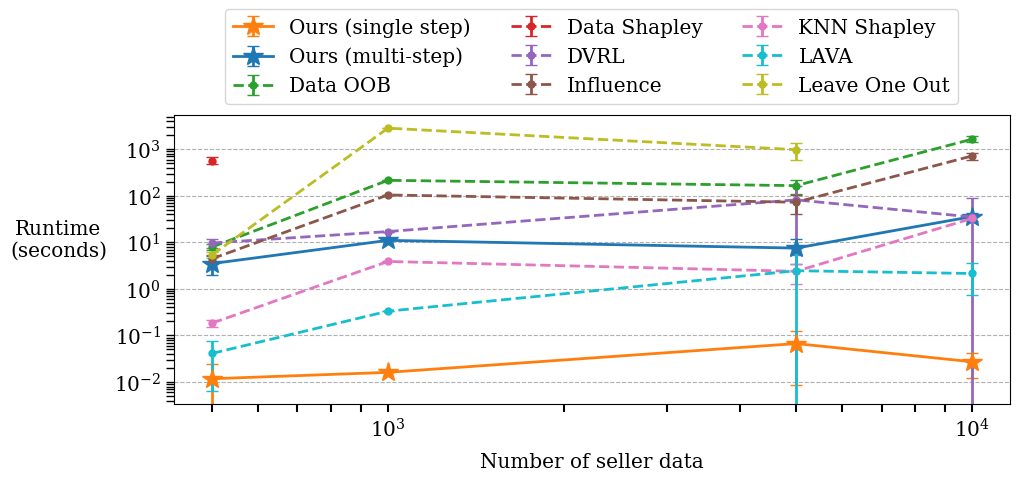

In [699]:
eval_range = list(np.arange(5, 115, 5))

plt.figure(figsize=(10, 5))

x = [500, 1000, 5000, 10000, 100000]
for k, v in runtime_mean.items():
    kwargs = config_style(k)
    if 'Ours' in k:
        kwargs['lw'] = 2
        kwargs['ms'] = 15
    else:
        kwargs['ls'] = '--'
    plt.errorbar(
        x[:len(v)],
        v,
        yerr=runtime_std[k],
        capsize=4,
        **kwargs,
    )
plt.xticks(x, fontsize="x-large")
plt.yticks(fontsize="x-large")
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1.5)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
# plt.xlim(5, 105)

plt.ylabel("Runtime\n(seconds)", fontsize="x-large", rotation=0, labelpad=40)
plt.xlabel(r"Number of seller data", fontsize="x-large", labelpad=8)

plt.grid(axis="y", ls="--")
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.001, 2000)

plt.legend(
    fontsize="x-large",
    bbox_to_anchor=(0.95, 1.40),
    loc="upper right",
    ncols=3,
)
plt.tight_layout(pad=0, w_pad=2)
# plt.savefig(figure_dir / f"runtime_num.eps", bbox_inches="tight")

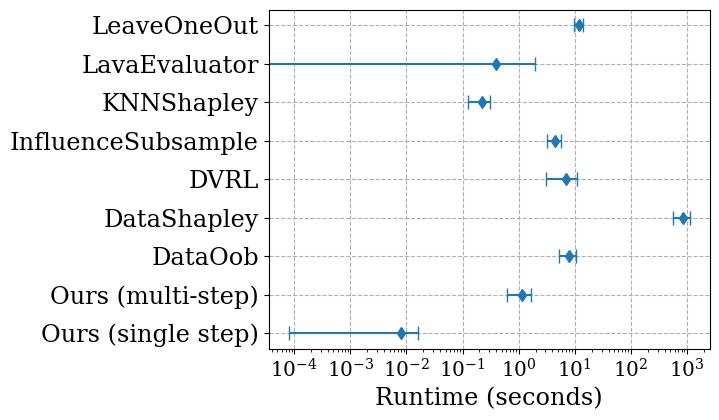

In [716]:
# run_dict = runtime_dim_100['runtimes']
run_dict = runtime_dim_10['runtimes']
# run_dict = runtime_num_1000['runtimes']
# run_dict = overfit_dim_results['runtimes']

plt.figure(figsize=(7, 4))
# errorbar(categories, values, yerr=errors, fmt='o', color='black', capsize=5)
plt.errorbar(
    y=list(run_dict.keys()),
    x=[v.mean() for v in run_dict.values()],
    xerr=[v.std() for v in run_dict.values()],
    # color=[color_map[k] for k in runtime_arr.keys()],
    fmt="d",
    capsize=5,
)
plt.xscale("log")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="xx-large")
plt.xlabel("Runtime (seconds)", fontsize="xx-large")
plt.grid(ls="--")
plt.tight_layout(pad=0, w_pad=0)
plt.savefig(figure_dir / f"gauss-baseline-runtime-1000.eps", bbox_inches="tight")

### Cost

In [ ]:
lw = 3
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

for i, (k, v) in enumerate(error_mat.items()):
    x = [int(x_i) for x_i in evals_3[0][k].keys()]
    y = np.mean(np.array([list(evals_3[j][k].values()) for j in rang]), 0)
    ls = "-" if k.startswith("exp_") or k == "one_step" else "--"
    c = f"C{i}" if k.startswith("exp_") else colors[k]
    # ax[0].plot([int(x_i) for x_i in x], y, label=k, ls=ls, lw=lw, c=c)
    # print(k)
    if k == "exp_design_10":
        k = "Exp. Design (100 steps)"
    elif k == "one_step":
        k = "Exp. Design (1 step)"
    ax[0].plot(x, y, label=k, ls=ls, lw=lw, c=c)

# for i, (k, v) in enumerate(evals_4.items()):
for i, k in enumerate(evals_4[0].keys()):
    if k in ["random_buyer", "random_seller", "exp_design_5", "exp_design_1"]:
        continue
    # x, y = zip(*v.items())
    x = [int(x_i) for x_i in evals_4[0][k].keys()]
    y = np.mean(np.array([list(evals_4[j][k].values()) for j in rang]), 0)
    ls = "-" if k.startswith("exp_") or k == "one_step" else "--"
    c = f"C{i}" if k.startswith("exp_") else colors[k]
    # ax[1].plot([int(x_i) for x_i in x], y, ls=ls, lw=lw, c=c)
    ax[1].plot(x, y, ls=ls, lw=lw, c=c)

ax[0].set_xlim(0, 30)
ax[1].set_xlim(0, 50)
ax[0].set_ylim(0, 5)
ax[1].set_ylim(0, 4000)
ax[0].set_title(r"Gaussian data", fontsize=18)
ax[1].set_title(r"Bone age data", fontsize=18)
ax[0].set_xlabel("Number of points selected", fontsize=18)
ax[1].set_xlabel("Number of points selected", fontsize=18)
ax[0].set_ylabel("MSE", fontsize=18, rotation=0, labelpad=24)
ax[1].set_ylabel("MSE", fontsize=18, rotation=0, labelpad=24)
ax[0].set_xticks([2, 10, 20, 30, 40, 50])
# plt.grid()
fig.legend(fontsize=18, bbox_to_anchor=(1.35, 1.05))
# plt.ylabel('Error', fontsize=16, rotation=0)
fig.tight_layout()
# plt.savefig('subset-compare-methods.eps', format='eps', bbox_inches='tight')
# plt.savefig('gaussian-compare-methods-cluster.eps', format='eps', bbox_inches='tight')

In [736]:
cost_results = load_results(
    "2024-01-23-194308-bone-clip-12000-square_root-results.json", budget_dict=True
)
cost_data = pickle.load(
    open(results_dir / "2024-01-23-194308-bone-clip-12000-square_root-data.pkl", "rb")
)
cost_weights = pickle.load(
    open(
        results_dir / "2024-01-23-194308-bone-clip-12000-square_root-weights.pkl", "rb"
    )
)

In [787]:
v.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145])

In [539]:
import matplotlib

get_err = lambda d: (
    d["eval_range"][d["mask"]],
    d["errors"]["Ours (multi-step)"].mean(0)[d["mask"]],
)
cmap = matplotlib.colormaps["viridis"].colors
cmap = matplotlib.colormaps["cividis"].colors
cmap = matplotlib.colormaps["plasma"].colors
colors = np.array(cmap)[np.linspace(0, 255, 6).astype(int)]

### Vary test batch size

In [961]:
gauss_32 = load_results("2024-01-23-180258-gaussian-10000-batch_size_32-results.json")
gauss_16 = load_results("2024-01-23-170409-gaussian-10000-batch_size_16-results.json")
gauss_8 = load_results("2024-01-23-171837-gaussian-10000-batch_size_8-results.json")
gauss_4 = load_results("2024-01-23-173521-gaussian-10000-batch_size_4-results.json")
gauss_2 = load_results("2024-01-23-181720-gaussian-10000-batch_size_2-results.json")
gauss_1 = load_results("2024-01-23-183954-gaussian-10000-batch_size_1-results.json")

mimic_32 = load_results("2024-01-31-005056-mimic-10000-batch_size_32-results.json")
mimic_16 = load_results("2024-01-31-012652-mimic-10000-batch_size_16-results.json")
mimic_8 = load_results("2024-01-31-020315-mimic-10000-batch_size_8-results.json")
mimic_4 = load_results("2024-01-31-023300-mimic-10000-batch_size_4-results.json")
mimic_2 = load_results("2024-01-31-030523-mimic-10000-batch_size_2-results.json")
mimic_1 = load_results("2024-01-31-033240-mimic-10000-batch_size_1-results.json")

bone_32 = load_results("2024-01-31-004826-bone-10000-batch_size_32-results.json")
bone_16 = load_results("2024-01-31-030616-bone-10000-batch_size_16-results.json")
bone_8 = load_results("2024-01-31-051354-bone-10000-batch_size_8-results.json")
bone_4 = load_results("2024-01-31-071427-bone-10000-batch_size_4-results.json")
bone_2 = load_results("2024-01-31-092133-bone-10000-batch_size_2-results.json")
bone_1 = load_results("2024-01-31-111716-bone-10000-batch_size_1-results.json")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


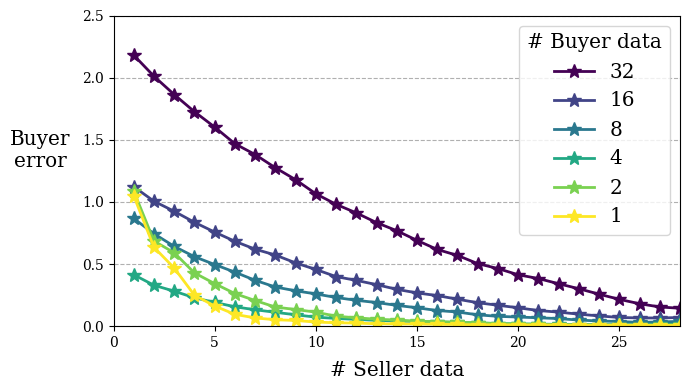

In [717]:
cmap = matplotlib.colormaps["viridis"].colors
colors = np.array(cmap)[np.linspace(0, 255, 6).astype(int)]

plt.figure(figsize=(7, 4))
plt.plot(*get_err(gauss_32), label=32, c=colors[0], lw=2, marker="*", ms=10)
plt.plot(*get_err(gauss_16), label=16, c=colors[1], lw=2, marker="*", ms=10)
plt.plot(*get_err(gauss_8), label=8, c=colors[2], lw=2, marker="*", ms=10)
plt.plot(*get_err(gauss_4), label=4, c=colors[3], lw=2, marker="*", ms=10)
plt.plot(*get_err(gauss_2), label=2, c=colors[4], lw=2, marker="*", ms=10)
plt.plot(*get_err(gauss_1), label=1, c=colors[5], lw=2, marker="*", ms=10)

plt.legend(title="Test batch size")
plt.grid(axis="y", ls="--")
plt.yticks(np.arange(0, 2.6, 0.5))
plt.xlim(0, 28)
plt.ylim(0, 2.5)
plt.xlabel("# Seller data", fontsize="x-large", labelpad=8)
plt.ylabel("Buyer\nerror", fontsize="x-large", rotation=0, labelpad=30)
plt.legend(fontsize="x-large", ncols=1, title="# Buyer data", title_fontsize="x-large")
plt.tight_layout()
plt.savefig(figure_dir / "gauss_vary_buyer_size.eps", format="eps", bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


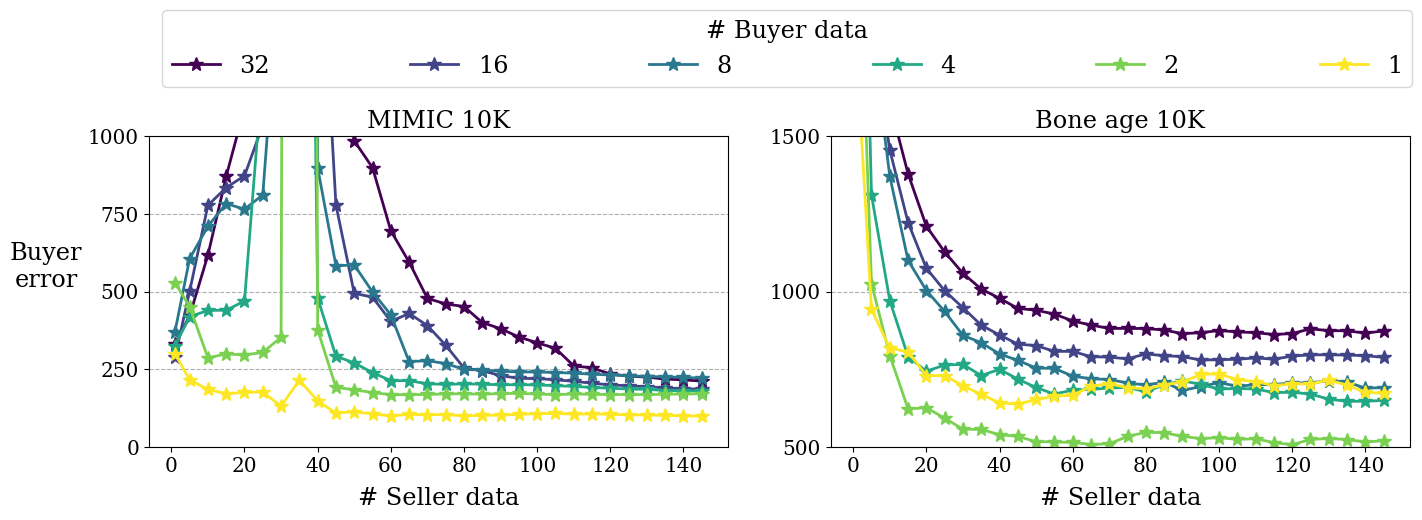

In [965]:
cmap = matplotlib.colormaps["viridis"].colors
colors = np.array(cmap)[np.linspace(0, 255, 6).astype(int)]

plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(14, 4), ncols=2)

ax[0].set_title("MIMIC 10K", fontsize="xx-large")
ax[1].set_title("Bone age 10K", fontsize="xx-large")

ax[0].grid(axis="y", ls="--")
ax[1].grid(axis="y", ls="--")

ax[0].plot(*get_err(mimic_32), label=32, c=colors[0], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(mimic_16), label=16, c=colors[1], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(mimic_8), label=8, c=colors[2], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(mimic_4), label=4, c=colors[3], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(mimic_2), label=2, c=colors[4], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(mimic_1), label=1, c=colors[5], lw=2, marker="*", ms=10)

ax[1].plot(*get_err(bone_32), c=colors[0], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_16), c=colors[1], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_8), c=colors[2], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_4), c=colors[3], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_2), c=colors[4], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_1), c=colors[5], lw=2, marker="*", ms=10)

ax[0].grid(axis="y", ls="--")
ax[1].grid(axis="y", ls="--")
ax[1].grid(axis="y", ls="--")
# plt.yticks(np.arange(0, 2.6, 0.5))
# plt.xlim(0, 28)

ax[0].set_xticks(np.arange(0, 150, 20))
ax[1].set_xticks(np.arange(0, 150, 20))
ax[0].set_yticks(np.arange(0, 1500, 250))
ax[1].set_yticks(np.arange(0, 3000, 500))

ax[0].set_xticklabels(ax[0].get_xticks(), fontsize="x-large")
ax[1].set_xticklabels(ax[1].get_xticks(), fontsize="x-large")
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize="x-large")
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize="x-large")

ax[0].set_ylim(0, 1000)
ax[1].set_ylim(500, 1500)

ax[0].set_ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=30)
ax[0].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[1].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)

fig.legend(
    fontsize="xx-large",
    bbox_to_anchor=(0.10, 0.28, 0.91, 1),
    loc="upper center",
    ncols=6,
    mode="expand",
    title="# Buyer data",
    title_fontsize="xx-large",
)
plt.tight_layout(pad=0, w_pad=3)
plt.savefig(figure_dir / f"vary_buyer.eps", bbox_inches="tight")

### Vary number of optimization iterations

In [329]:
cmap = matplotlib.colormaps["plasma"].colors
colors = np.array(cmap)[np.linspace(0, 255, 5).astype(int)]

In [997]:
gauss_1 = load_results("2024-01-26-041551-gaussian-10000-num_iters_1-results.json")
gauss_5 = load_results("2024-01-26-063506-gaussian-10000-num_iters_5-results.json")
gauss_10 = load_results("2024-01-26-035657-gaussian-10000-num_iters_10-results.json")
gauss_50 = load_results("2024-01-26-033656-gaussian-10000-num_iters_50-results.json")
gauss_100 = load_results("2024-01-26-031924-gaussian-10000-num_iters_100-results.json")
gauss_500 = load_results("2024-01-26-024551-gaussian-10000-num_iters_500-results.json")
gauss_1000 = load_results("2024-01-26-020844-gaussian-10000-num_iters_1000-results.json")

bone_1 = load_results("2024-01-25-170928-bone-10000-num_iters_1-results.json")
bone_10 = load_results("2024-01-25-161411-bone-10000-num_iters_10-results.json")
bone_50 = load_results("2024-01-25-150009-bone-10000-num_iters_50-results.json")
bone_100 = load_results("2024-01-24-201547-bone-10000-num_iters_100-results.json")
bone_500 = load_results("2024-01-23-234532-bone-10000-num_iters_500-results.json")
bone_1000 = load_results("2024-01-23-205307-bone-10000-num_iters_1000-results.json")

In [998]:
cmap = matplotlib.colormaps["plasma"].colors
colors = np.array(cmap)[np.linspace(0, 255, 6).astype(int)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


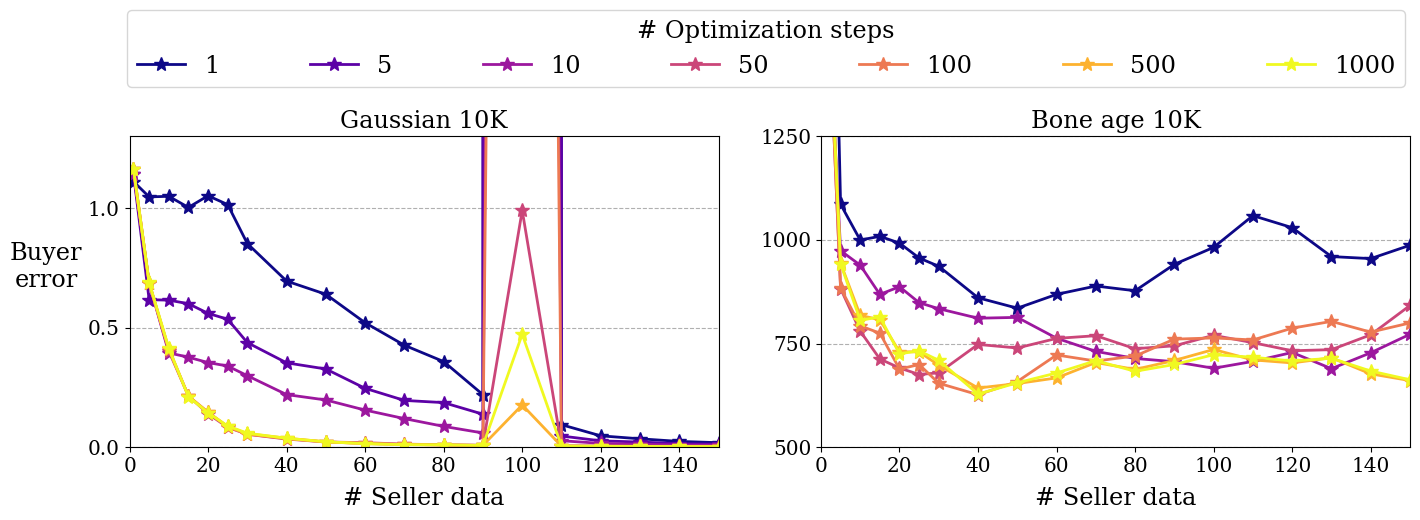

In [1013]:
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(14, 4), ncols=2)

ax[0].set_title("Gaussian 10K", fontsize="xx-large")
ax[1].set_title("Bone age 10K", fontsize="xx-large")

ax[0].grid(axis="y", ls="--")
ax[1].grid(axis="y", ls="--")

colors = np.array(cmap)[np.linspace(0, 255, 7).astype(int)]

ax[0].plot(*get_err(gauss_1), label=1, c=colors[0], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(gauss_5), label=5, c=colors[1], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(gauss_10), label=10, c=colors[2], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(gauss_50), label=50, c=colors[3], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(gauss_100), label=100, c=colors[4], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(gauss_500), label=500, c=colors[5], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(gauss_1000), label=1000, c=colors[6], lw=2, marker="*", ms=10)


ax[1].plot(*get_err(bone_1), c=colors[0], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_10),  c=colors[2], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_50),  c=colors[3], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_100),  c=colors[4], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_500),  c=colors[5], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_1000), c=colors[6], lw=2, marker="*", ms=10)

ax[0].grid(axis="y", ls="--")
ax[1].grid(axis="y", ls="--")
# plt.yticks(np.arange(0, 2.6, 0.5))
# plt.xlim(0, 28)

ax[0].set_xticks(np.arange(0, 150, 20))
ax[1].set_xticks(np.arange(0, 150, 20))
ax[0].set_yticks(np.arange(0, 2.1, 0.5))
ax[1].set_yticks(np.arange(0, 3000, 250))

ax[0].set_xticklabels(ax[0].get_xticks(), fontsize="x-large")
ax[1].set_xticklabels(ax[1].get_xticks(), fontsize="x-large")
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize="x-large")
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize="x-large")

ax[0].set_xlim(0, 150)
ax[1].set_xlim(0, 150)
ax[0].set_ylim(0, 1.3)
ax[1].set_ylim(500, 1250)

ax[0].set_ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=30)
ax[0].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[1].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)

fig.legend(
    fontsize="xx-large",
    bbox_to_anchor=(0.075, 0.28, 0.93, 1),
    loc="upper center",
    ncols=7,
    mode="expand",
    title="# Optimization steps",
    title_fontsize="xx-large",
)
plt.tight_layout(pad=0, w_pad=3)
plt.savefig(figure_dir / f"vary_steps.eps", bbox_inches="tight")

### Regularization

In [966]:
reg_0 = load_results("2024-01-26-060925-mimic-35000-cov_reg_0-results.json", skip_mask=True)
reg_2 = load_results("2024-01-26-063851-mimic-35000-cov_reg_2-results.json", skip_mask=True)
reg_4 = load_results("2024-01-26-071108-mimic-35000-cov_reg_4-results.json", skip_mask=True)
reg_6 = load_results("2024-01-26-074115-mimic-35000-cov_reg_6-results.json", skip_mask=True)
reg_8 = load_results("2024-01-26-081350-mimic-35000-cov_reg_8-results.json", skip_mask=True)
reg_1 = load_results("2024-01-26-084208-mimic-35000-cov_reg_8-results.json", skip_mask=True)

In [967]:
# cmap = matplotlib.colormaps["viridis"].colors
cmap = matplotlib.colormaps["inferno"].colors
colors = np.array(cmap)[np.linspace(50, 240, 6).astype(int)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


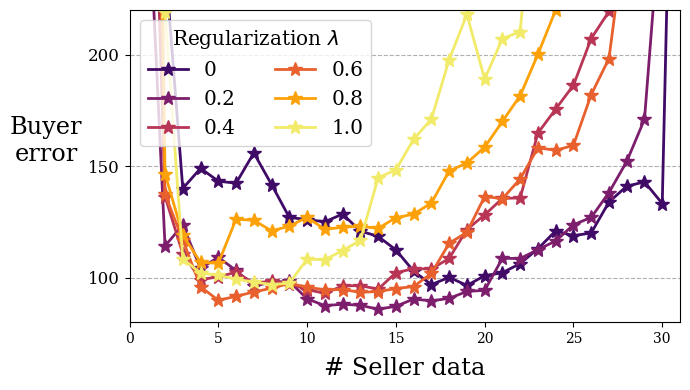

In [968]:
plt.figure(figsize=(7, 4))
plt.plot(*get_err(reg_0), label=0, c=colors[0], lw=2, marker="*", ms=10)
plt.plot(*get_err(reg_2), label=0.2, c=colors[1], lw=2, marker="*", ms=10)
plt.plot(*get_err(reg_4), label=0.4, c=colors[2], lw=2, marker="*", ms=10)
plt.plot(*get_err(reg_6), label=0.6, c=colors[3], lw=2, marker="*", ms=10)
plt.plot(*get_err(reg_8), label=0.8, c=colors[4], lw=2, marker="*", ms=10)
plt.plot(*get_err(reg_1), label=1.0, c=colors[5], lw=2, marker="*", ms=10)
plt.grid(axis="y", ls="--")
# plt.xticks(range(0, 31, 5), fontsize='large')
plt.yticks(range(0, 300, 50), fontsize='large')
plt.xlim(0, 31)
plt.ylim(80, 220)
plt.xlabel("# Seller data", fontsize="xx-large", labelpad=8)
plt.ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=30)
plt.legend(
    fontsize="x-large", ncols=2, loc='upper left', title=r"Regularization $\lambda$", title_fontsize="x-large"
)
plt.tight_layout()
plt.savefig(figure_dir / "vary_reg_mimic.eps", format="eps", bbox_inches="tight")

In [972]:
drug_reg_0 = load_results("2024-01-26-061024-drug-3000-cov_reg_0-results.json")
drug_reg_2 = load_results("2024-01-26-082852-drug-3000-cov_reg_2-results.json")
drug_reg_4 = load_results("2024-01-26-112645-drug-3000-cov_reg_4-results.json")
drug_reg_6 = load_results("2024-01-26-140312-drug-3000-cov_reg_6-results.json")
drug_reg_8 = load_results("2024-01-26-164845-drug-3000-cov_reg_8-results.json")
drug_reg_1 = load_results("2024-01-26-211730-drug-3000-cov_reg_1-results.json")

bone_reg_0 = load_results("2024-01-28-210224-bone-12000-cov_reg_0-results.json")
bone_reg_2 = load_results("2024-01-29-022305-bone-12000-cov_reg_2-results.json")
bone_reg_4 = load_results("2024-01-29-054318-bone-12000-cov_reg_4-results.json")
bone_reg_6 = load_results("2024-01-29-091149-bone-12000-cov_reg_6-results.json")
bone_reg_8 = load_results("2024-01-29-124836-bone-12000-cov_reg_8-results.json")
bone_reg_1 = load_results("2024-01-29-155037-bone-12000-cov_reg_1-results.json")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


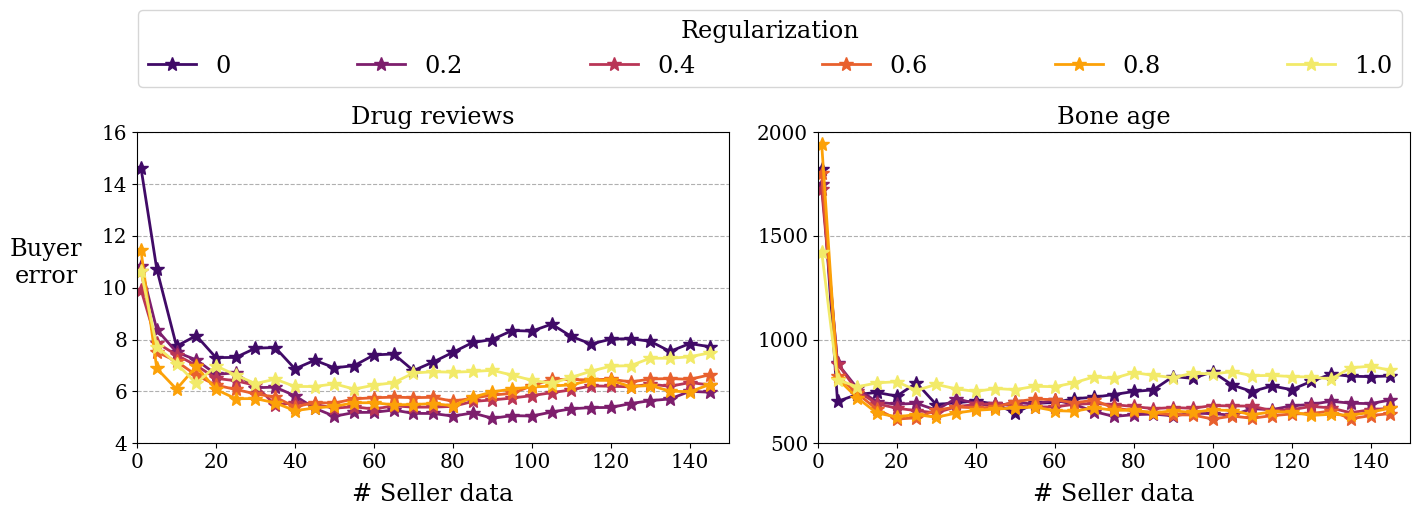

In [984]:
plt.rcParams["font.family"] = "serif"
# fig, ax = plt.subplots(figsize=(16, 5), ncols=3)
fig, ax = plt.subplots(figsize=(14, 4), ncols=2)

ax[0].plot(*get_err(drug_reg_0), label=0, c=colors[0], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(drug_reg_2), label=0.2, c=colors[1], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(drug_reg_4), label=0.4, c=colors[2], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(drug_reg_6), label=0.6, c=colors[3], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(drug_reg_8), label=0.8, c=colors[4], lw=2, marker="*", ms=10)
ax[0].plot(*get_err(drug_reg_1), label=1.0, c=colors[5], lw=2, marker="*", ms=10)

ax[1].plot(*get_err(bone_reg_0), c=colors[0],  lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_reg_2), c=colors[1], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_reg_4), c=colors[2], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_reg_6), c=colors[3], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_reg_8), c=colors[4], lw=2, marker="*", ms=10)
ax[1].plot(*get_err(bone_reg_1), c=colors[5], lw=2, marker="*", ms=10)

ax[0].set_title("Drug reviews", fontsize="xx-large")
ax[1].set_title("Bone age", fontsize="xx-large")

ax[0].grid(axis="y", ls="--")
ax[1].grid(axis="y", ls="--")

# ax[0].set_xticks(np.arange(0, 101, 10), fontsize='large')
# plt.yticks(np.arange(4, 17, 1), fontsize='large')
# ax[0].set_xlim(0, 101)
# plt.ylim(4.5, 15)
ax[0].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[1].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
ax[0].set_ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=40)

# ax[0].set_ylabel("Buyer\nerror", fontsize="xx-large", rotation=0, labelpad=35)
# ax[0].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
# ax[1].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
# ax[2].set_xlabel("# Seller data", fontsize="xx-large", labelpad=8)
# ax[0].set_title("Fitzpatrick photos", fontsize="xx-large")
# ax[1].set_title("Bone age x-rays", fontsize="xx-large")
# ax[2].set_title("Druglib text reviews", fontsize="xx-large")

ax[0].set_xticks(np.arange(0, 150, 20))
ax[1].set_xticks(np.arange(0, 150, 20))
# ax[2].set_xticks(np.arange(0, 150, 20))

ax[0].set_yticks(np.arange(0, 17, 2))
ax[1].set_yticks(np.arange(0, 2001, 500))
# ax[2].set_yticks(np.arange(0, 50, 5))

ax[0].set_xticklabels(ax[0].get_xticks(), fontsize="x-large")
ax[1].set_xticklabels(ax[1].get_xticks(), fontsize="x-large")
# ax[2].set_xticklabels(ax[2].get_xticks(), fontsize="x-large")
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize="x-large")
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize="x-large")
# ax[2].set_yticklabels(ax[2].get_yticks(), fontsize="x-large")

ax[0].set_xlim(0, 150)
ax[1].set_xlim(0, 150)
# ax[2].set_xlim(0, 100)

ax[0].set_ylim(4, 16)
ax[1].set_ylim(500, 2000)
# ax[2].set_ylim(5, 25)

# ax[0].grid(axis="y", ls="--")
# ax[1].grid(axis="y", ls="--")
# ax[2].grid(axis="y", ls="--")

fig.legend(
    fontsize="xx-large",
    bbox_to_anchor=(0.083, 0.27, 0.92, 1),
    loc="upper center",
    ncols=6,
    mode="expand",
    title="Regularization",
    title_fontsize="xx-large",
)
plt.tight_layout(pad=0, w_pad=2)
plt.savefig(figure_dir / f"regularization.eps", bbox_inches="tight")